In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import matplotlib

%matplotlib inline

In [4]:
np.random.seed(111)

In [5]:
def CreateDataSet(Number=1):
    Output=[]
    
    for i in range(Number):
        # DatetimeIndex contains every monday
        rng=pd.date_range(start='1/1/2009',end='12/31/2012',freq='W-MON') 

        data=np.random.randint(low=25,high=1000,size=len(rng))

        #status pool
        status=[1,2,3]

        random_status=[status[np.random.randint(low=0,high=len(status))] for i in range(len(rng))]

        #state pool
        states=['GA','FL','fl','NY','NJ','TX']

        random_states=[states[np.random.randint(low=0,high=len(states))] for i in range(len(rng))]

        Output.extend(zip(random_states, random_status, data, rng))
    
    return Output    
    

In [6]:
dataset=CreateDataSet(4)

df=pd.DataFrame(data=dataset,columns=['State','Status','CustomerCount','StatusDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836 entries, 0 to 835
Data columns (total 4 columns):
State            836 non-null object
Status           836 non-null int64
CustomerCount    836 non-null int64
StatusDate       836 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 26.2+ KB


In [7]:
df.head()

,State,Status,CustomerCount,StatusDate
0,GA,1,877,2009-01-05
1,FL,1,901,2009-01-12
2,fl,3,749,2009-01-19
3,FL,3,111,2009-01-26
4,GA,1,300,2009-02-02


In [8]:
df.to_excel('Lesson3.xlsx', index=False)

In [9]:
df=pd.read_excel('Lesson3.xlsx', 0, index_col='StatusDate')

In [10]:
df.dtypes

State            object
Status            int64
CustomerCount     int64
dtype: object

In [11]:
df.State.unique()

array(['GA', 'FL', 'fl', 'TX', 'NY', 'NJ'], dtype=object)

In [12]:
df.State=df.State.apply(lambda x: x.upper())

In [13]:
df.State.unique()

array(['GA', 'FL', 'TX', 'NY', 'NJ'], dtype=object)

In [14]:
mask=df['Status']==1
type(mask)

pandas.core.series.Series

In [15]:
df=df[mask]

In [16]:
mask=df['State']=='NJ'
df['State'][mask]='NY'
df.State.unique()

array(['GA', 'FL', 'NY', 'TX'], dtype=object)

In [17]:
df.Status.unique()

array([1], dtype=int64)

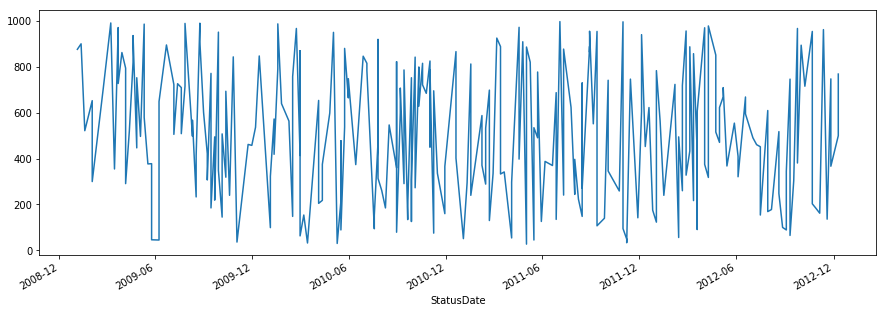

In [18]:
df.CustomerCount.plot(figsize=(15,5))

In [19]:
df.head()

,State,Status,CustomerCount
StatusDate,,,
2009-01-05,GA,1,877
2009-01-12,FL,1,901
2009-02-02,GA,1,300
2009-03-09,NY,1,992
2009-04-06,FL,1,291


In [20]:
Daily = df.reset_index().groupby(['State','StatusDate']).sum()
Daily.head()
del Daily['Status']
Daily.head()

# groupby with a list of values can group by all combinations of values
StateYearMonth=Daily.groupby([Daily.index.get_level_values(0), Daily.index.get_level_values(1).year, Daily.index.get_level_values(1).month])

Daily['Lower']=StateYearMonth['CustomerCount'].transform(lambda x: x.quantile(q=.25) - (1.5 * x.quantile(q=.75) - x.quantile(q=.25)))
Daily['Upper']=StateYearMonth['CustomerCount'].transform(lambda x: x.quantile(q=.75) + (1.5 * x.quantile(q=.75) - x.quantile(q=.25)))

Daily['Outlier']=(Daily['CustomerCount'] < Daily['Lower']) | (Daily['CustomerCount'] > Daily['Upper'])

Daily=Daily[Daily['Outlier']==False]

Daily.head()

CustomerCount  Lower   Upper  Outlier
State StatusDate                                       
FL    2009-01-12            901  450.5  1351.5    False
      2009-02-02            653  326.5   979.5    False
      2009-03-23            752  376.0  1128.0    False
      2009-04-06           1086  543.0  1629.0    False
      2009-06-08            649  324.5   973.5    False

In [21]:
# group customer count by statusdate, remove state
ALL=pd.DataFrame(Daily['CustomerCount'].groupby(Daily.index.get_level_values(1)).sum())
ALL.columns=['CustomerCount']

In [24]:
YearMonth=ALL.groupby([lambda x:x.year, lambda x:x.month])
YearMonth.columns=['CustomerCount']

ALL['Max']=YearMonth['CustomerCount'].transform(lambda x:x.max()) # we can't use apply
# because apply will return one line per group
# transform will return one line per origin line

ALL.head()

,CustomerCount,Max
StatusDate,,
2009-01-05,877,901
2009-01-12,901,901
2009-01-19,522,901
2009-02-02,953,953
2009-02-23,710,953


In [25]:
data=[1000,2000,3000]
idx=pd.date_range(start='12/31/2011',end='12/31/2013',freq='A')
BHAG=pd.DataFrame(data,index=idx,columns=['BHAG'])
BHAG

,BHAG
2011-12-31,1000
2012-12-31,2000
2013-12-31,3000


In [26]:
combined=pd.concat([ALL,BHAG],axis=0)
combined=combined.sort_index(axis=0)
combined.tail()

,BHAG,CustomerCount,Max
2012-11-19,NaN,136.0,1115.0
2012-11-26,NaN,1115.0,1115.0
2012-12-10,NaN,1269.0,1269.0
2012-12-31,2000.0,NaN,NaN
2013-12-31,3000.0,NaN,NaN


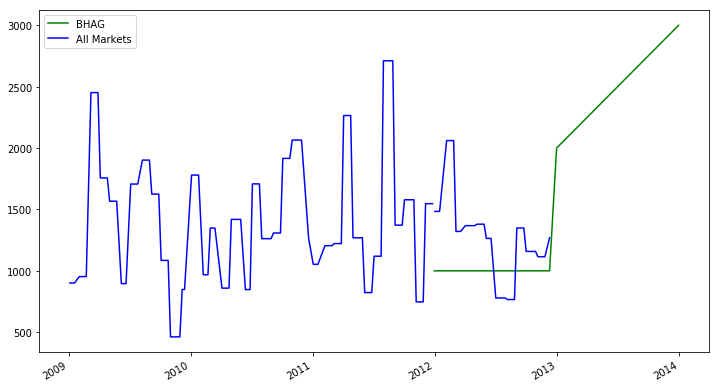

In [33]:
fig,axes=plt.subplots(figsize=(12,7))
combined['BHAG'].fillna(method='pad').plot(color='green',label='BHAG')
combined['Max'].plot(color='blue',label='All Markets')
plt.legend(loc='best');

In [34]:
Year=combined.groupby(lambda x:x.year).max()
Year

,BHAG,CustomerCount,Max
2009,NaN,2452.0,2452.0
2010,NaN,2065.0,2065.0
2011,1000.0,2711.0,2711.0
2012,2000.0,2061.0,2061.0
2013,3000.0,NaN,NaN


In [35]:
Year['YR_PCT_Change']=Year['Max'].pct_change(periods=1)
Year

,BHAG,CustomerCount,Max,YR_PCT_Change
2009,NaN,2452.0,2452.0,NaN
2010,NaN,2065.0,2065.0,-0.157830
2011,1000.0,2711.0,2711.0,0.312833
2012,2000.0,2061.0,2061.0,-0.239764
2013,3000.0,NaN,NaN,NaN


In [36]:
Year.ix?

In [39]:
(1+Year.loc[2012,'YR_PCT_Change'])*Year.loc[2012,'Max']

1566.8465510881595

In [40]:
Daily.head()

CustomerCount  Lower   Upper  Outlier
State StatusDate                                       
FL    2009-01-12            901  450.5  1351.5    False
      2009-02-02            653  326.5   979.5    False
      2009-03-23            752  376.0  1128.0    False
      2009-04-06           1086  543.0  1629.0    False
      2009-06-08            649  324.5   973.5    False

In [41]:
ALL.head()

,CustomerCount,Max
StatusDate,,
2009-01-05,877,901
2009-01-12,901,901
2009-01-19,522,901
2009-02-02,953,953
2009-02-23,710,953


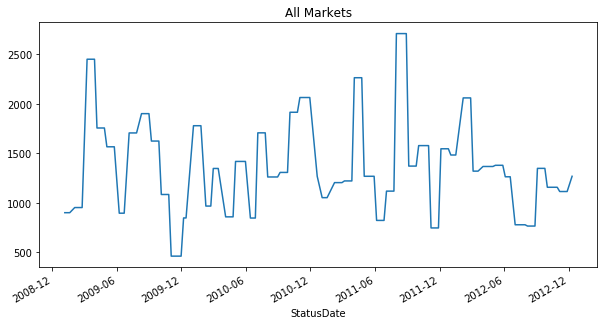

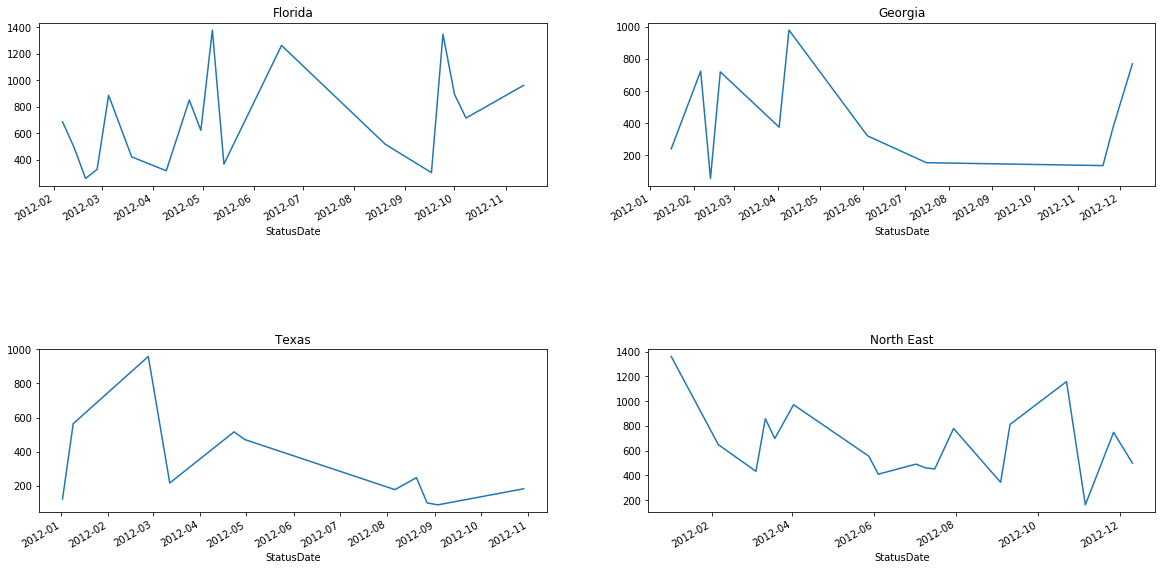

In [43]:
ALL['Max'].plot(figsize=(10,5));plt.title('All Markets')

fig, axes=plt.subplots(nrows=2,ncols=2,figsize=(20,10))
fig.subplots_adjust(hspace=1.0)

Daily.loc['FL']['CustomerCount']['2012':].fillna(method='pad').plot(ax=axes[0,0])
Daily.loc['GA']['CustomerCount']['2012':].fillna(method='pad').plot(ax=axes[0,1])
Daily.loc['TX']['CustomerCount']['2012':].fillna(method='pad').plot(ax=axes[1,0])
Daily.loc['NY']['CustomerCount']['2012':].fillna(method='pad').plot(ax=axes[1,1])

axes[0,0].set_title('Florida')
axes[0,1].set_title('Georgia')
axes[1,0].set_title('Texas')
axes[1,1].set_title('North East')
